In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# MobileNetV2

In [2]:
# Config
csv_files = {
    "mobv2_adam_lr2_dropout15": "results/history_mobv2_adam_lr2_dropout15_bn.csv",
    "mobv2_adam_lr3_dropout0": "results/history_mobv2_adam_lr3_dropout0_bn.csv",
    "mobv2_adam_lr3_dropout15": "results/history_mobv2_adam_lr3_dropout15_bn.csv",
    "mobv2_adam_lr3_dropout20": "results/history_mobv2_adam_lr3_dropout20_bn.csv",
    "mobv2_sgd_mom09_lr3_dropout15": "results/history_mobv2_sgd_mom09_lr3_dropout15_bn.csv"
}

In [3]:
baseline_f1 = 0.0488
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
model_histories = {name: pd.read_csv(path) for name, path in csv_files.items()}

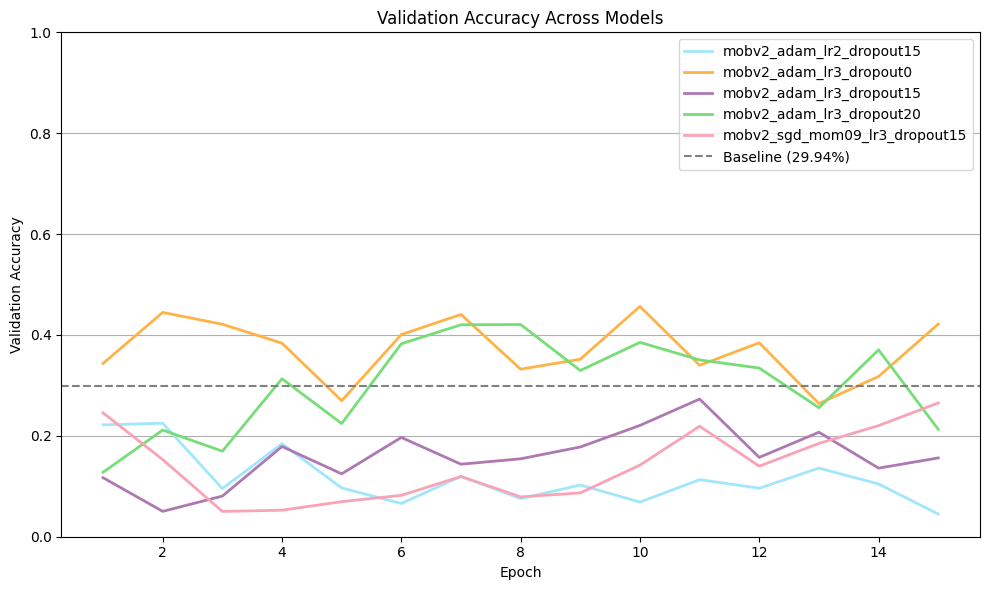

In [4]:
pastel_colors = ["#a0e6fc", '#FFB347', "#AE79B2", '#77DD77', "#F9A3B6"]  # adjust length if needed

plt.figure(figsize=(10, 6))

for color, (name, df) in zip(pastel_colors, model_histories.items()):
    plt.plot(df['epoch'], df['val_acc'], label=name, color=color, linewidth=2)

plt.axhline(y=0.2994, color='gray', linestyle='--', label='Baseline (29.94%)')
plt.title("Validation Accuracy Across Models")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig("results/mobv2_val_accuracy_comparison.png")
plt.show()

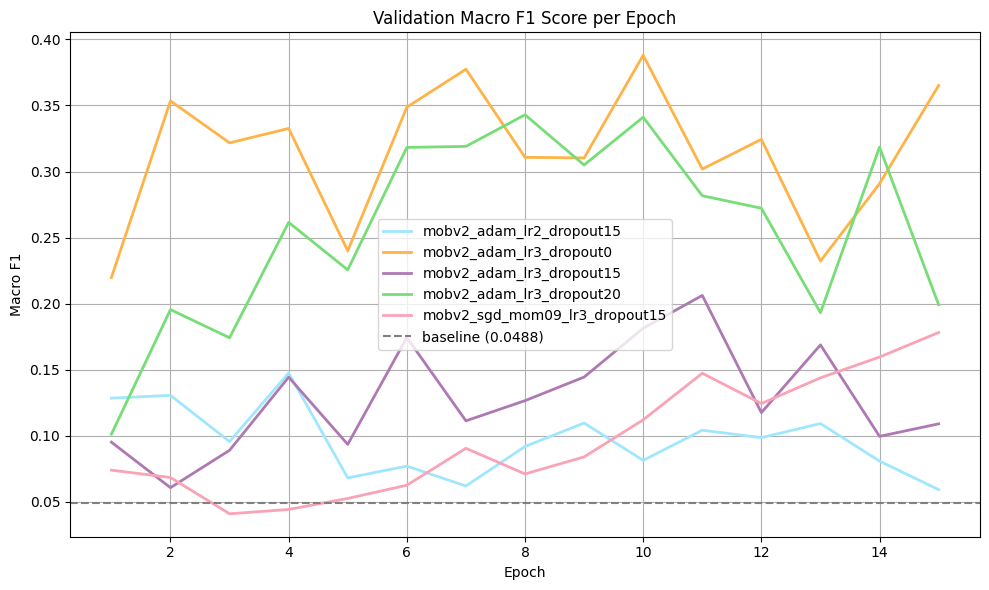

In [5]:
pastel_colors = ["#a0e6fc", '#FFB347', "#AE79B2", '#77DD77', "#F9A3B6"]  # adjust length if needed

# Plot macro F1 over epochs with baseline
plt.figure(figsize=(10, 6))
for color, (name, df) in zip(pastel_colors, model_histories.items()):
    plt.plot(df["epoch"], df["val_f1_macro"], label=name, color=color, linewidth=2)

plt.axhline(y=baseline_f1, color='gray', linestyle='--', label='baseline (0.0488)')
plt.title("Validation Macro F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/mobv2_macro_f1_comparison.png")
plt.show()

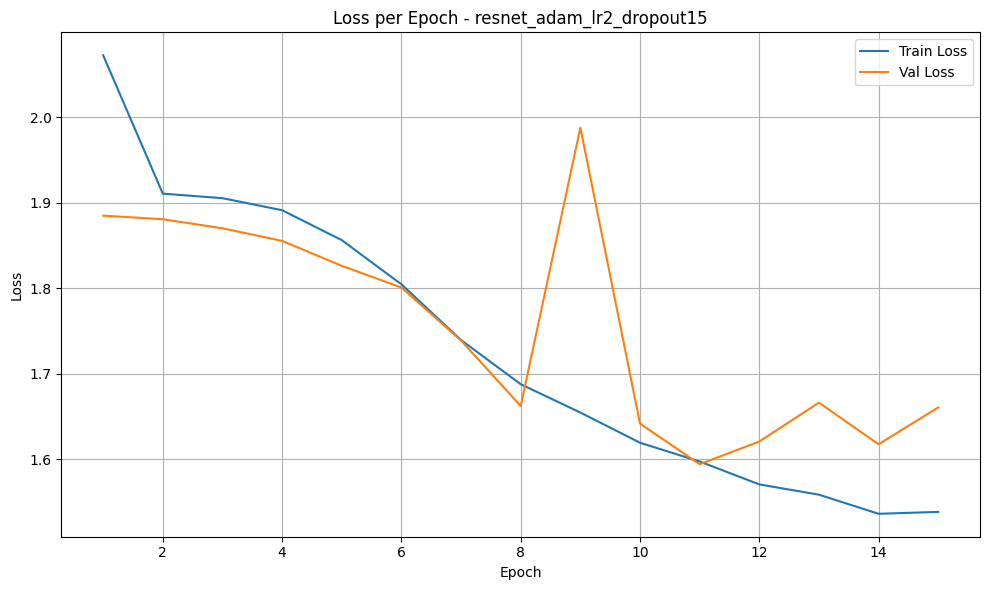

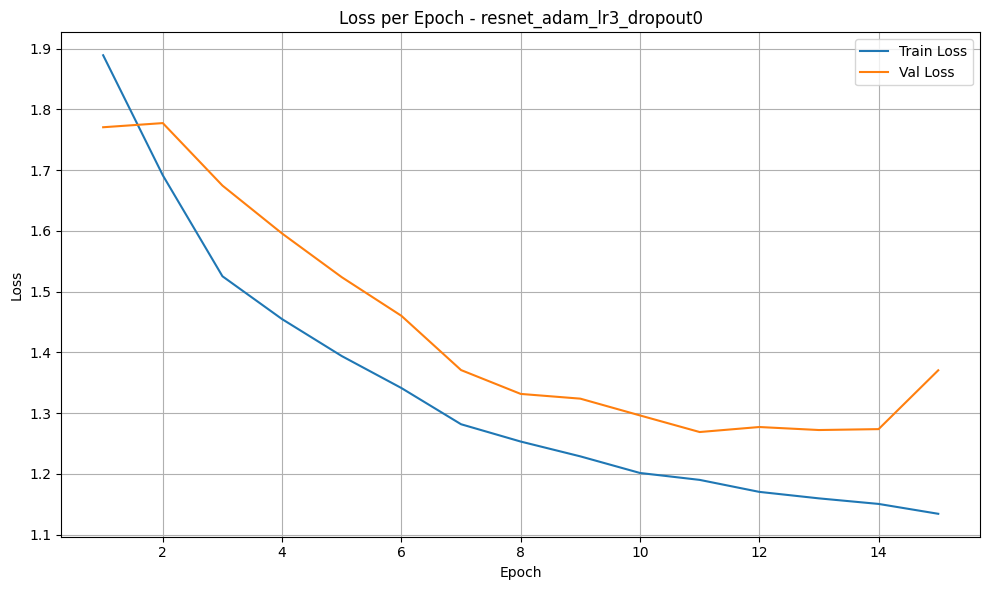

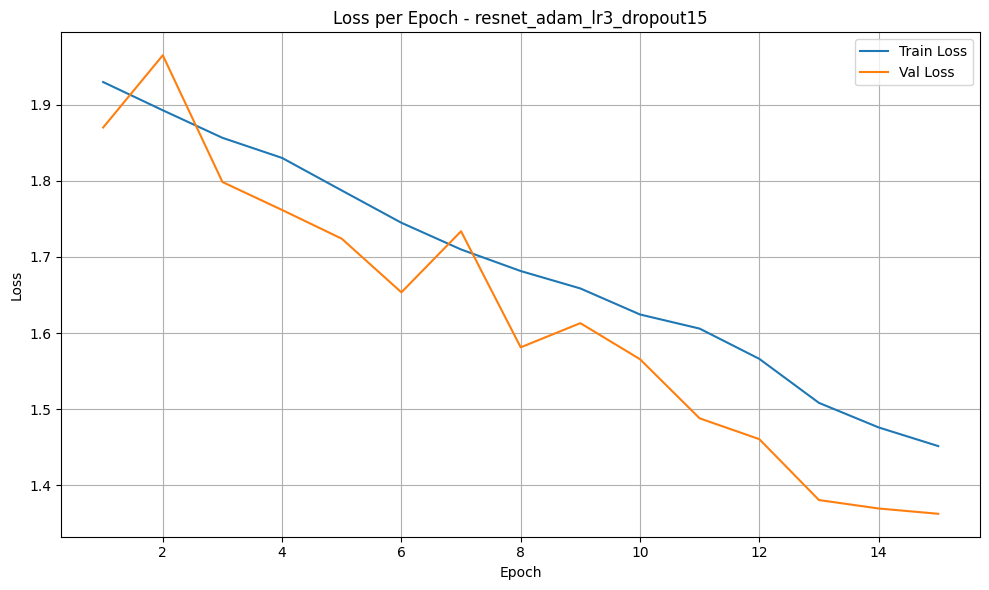

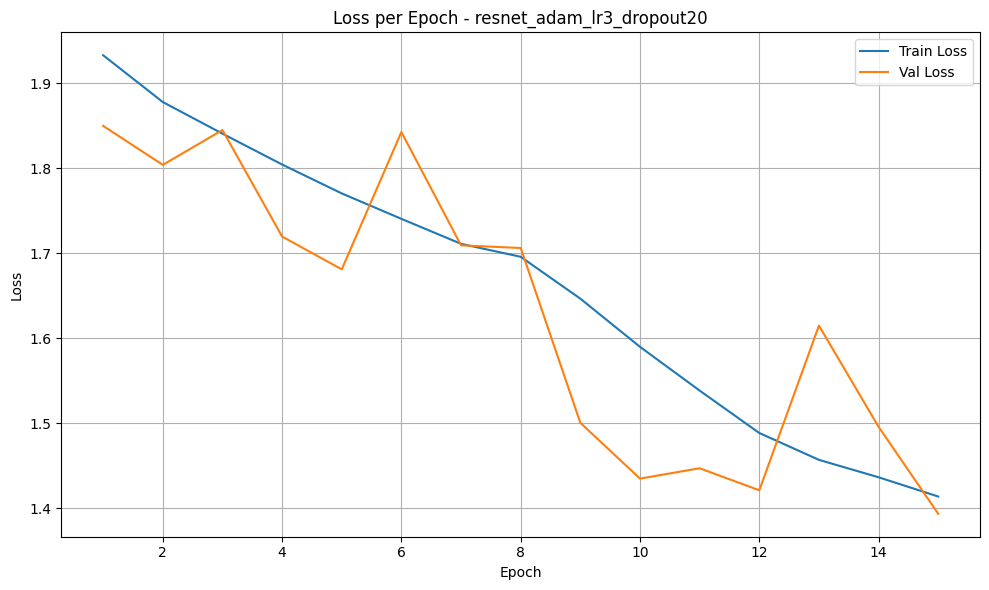

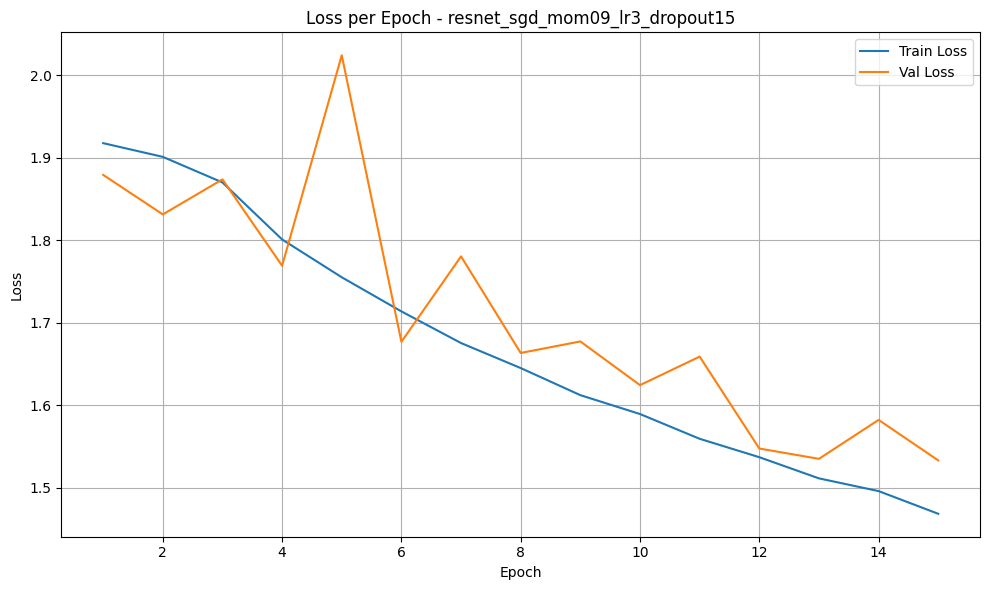

In [31]:
# Train & Val Loss per model
for name, df in model_histories.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
    plt.plot(df["epoch"], df["val_loss"], label="Val Loss")
    plt.title(f"Loss per Epoch - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"results/loss_curve_{name}.png")
    plt.show()

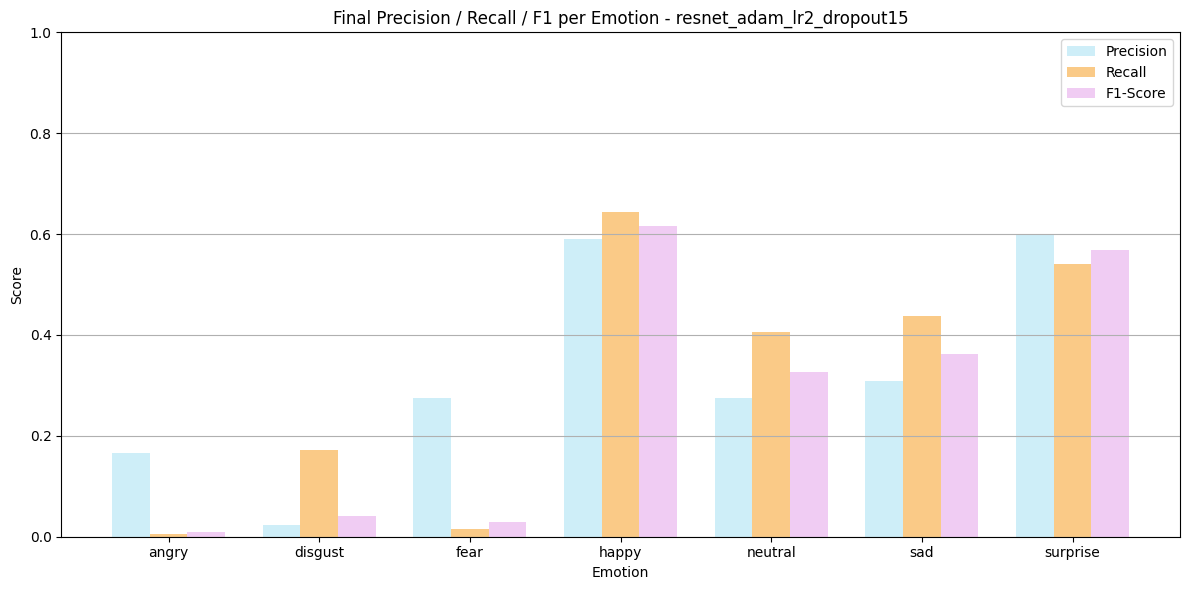

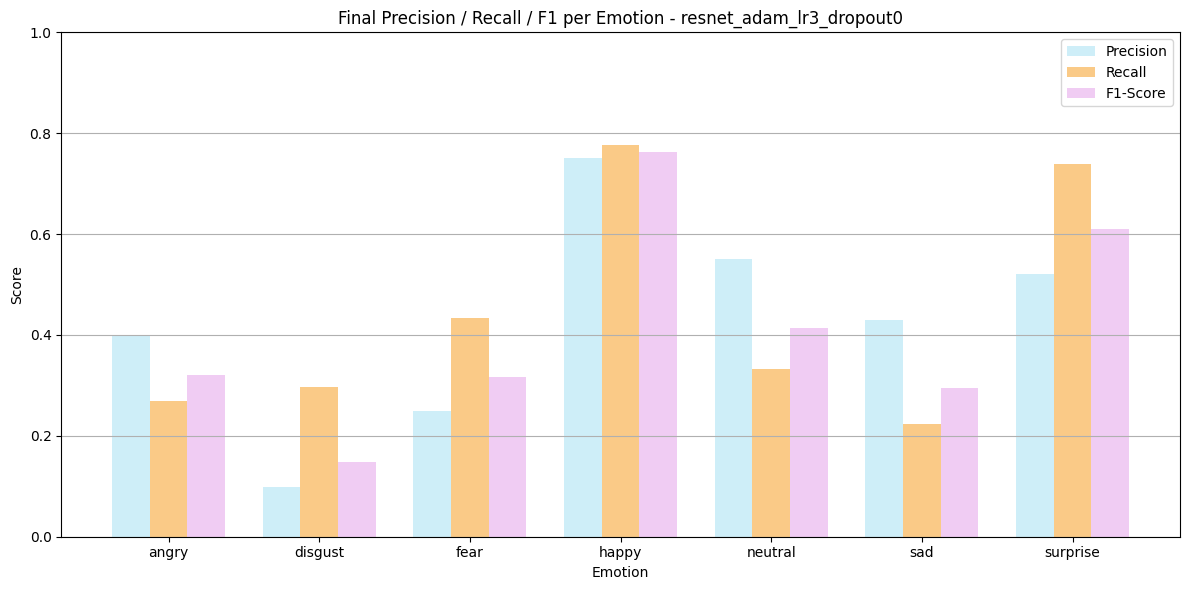

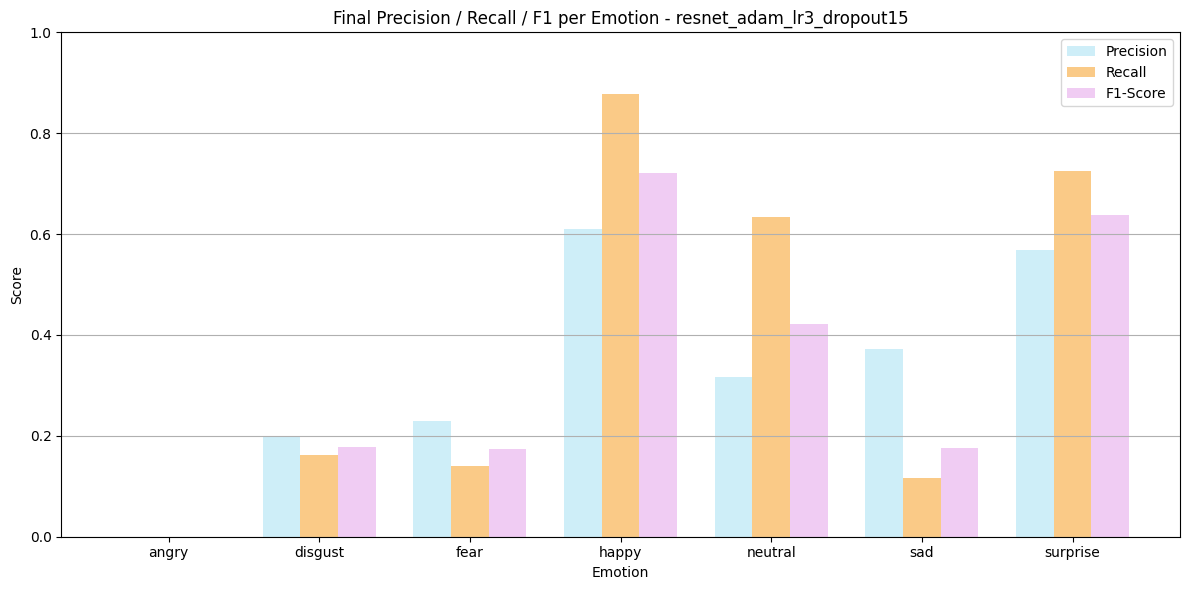

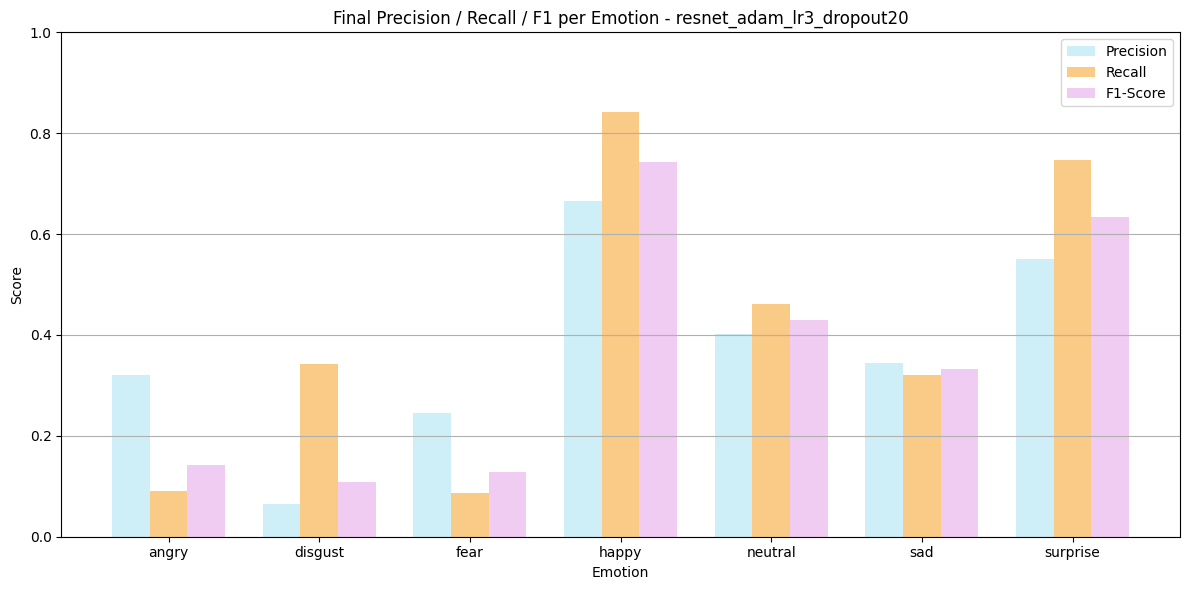

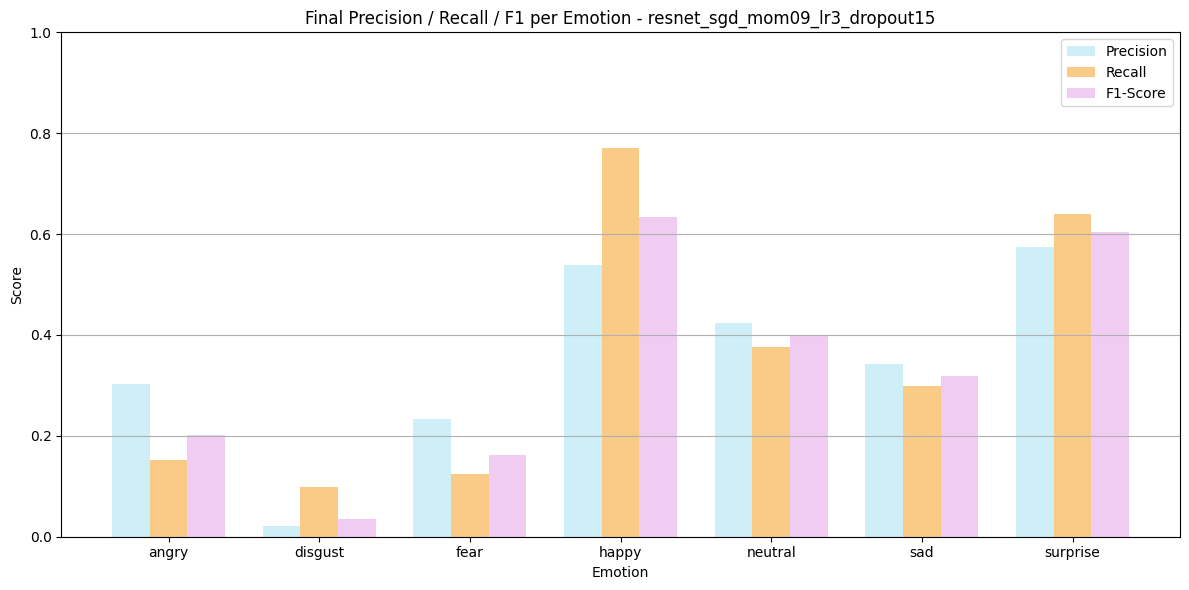

In [32]:
# Final F1 / Precision / Recall per emotion per model
for name, df in model_histories.items():
    last_epoch = df.iloc[-1]
    precisions = [last_epoch[f"{emo}_precision"] for emo in emotion_labels]
    recalls = [last_epoch[f"{emo}_recall"] for emo in emotion_labels]
    f1s = [last_epoch[f"{emo}_f1-score"] for emo in emotion_labels]

    x = range(len(emotion_labels))
    width = 0.25

    # Pastel colors
    pastel_precision = "#ceeef8"  # pastel blue
    pastel_recall = "#FACA87"     # pastel orange
    pastel_f1 = "#F0CCF3"         # pastel purple

    plt.figure(figsize=(12, 6))
    plt.bar([i - width for i in x], precisions, width=width, label="Precision", color=pastel_precision)
    plt.bar(x, recalls, width=width, label="Recall", color=pastel_recall)
    plt.bar([i + width for i in x], f1s, width=width, label="F1-Score", color=pastel_f1)

    plt.xticks(ticks=x, labels=emotion_labels)
    plt.title(f"Final Precision / Recall / F1 per Emotion - {name}")
    plt.xlabel("Emotion")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"results/emotion_metrics_{name}.png")
    plt.show()

## Clustering of emotions

In [ ]:
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import os
import torch.nn.functional as F

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

In [38]:
# Define transformation for test set
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
test_dataset = datasets.ImageFolder('./data/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define model (same architecture as in training)
class InvertedResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio, dropout_rate=0.0):
        super().__init__()
        self.use_res_connect = stride == 1 and in_channels == out_channels
        hidden_dim = in_channels * expand_ratio

        layers = []

        # Expansion
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True)
            ])

        # Depthwise
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ])
        
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))

        # Projection
        layers.extend([
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ])

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.block(x)
        else:
            return self.block(x)

class MobileNetV2_48x48(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.0):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        # Initial convolution layer
        self.init_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # 48x48 input
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        # Bottleneck configuration: (t, c, n, s)
        bottlenecks_cfg = [
            (1, 16, 1, 1),
            (6, 24, 1, 1),  # no downsampling yet
            (6, 32, 2, 2),
            (6, 64, 1, 2),
            (6, 96, 1, 1),
        ]

        blocks = []
        in_channels = 32
        for t, out_channels, n, s in bottlenecks_cfg:
            for i in range(n):
                stride = s if i == 0 else 1
                blocks.append(InvertedResidualBlock(in_channels, out_channels, stride, t, dropout_rate))
                in_channels = out_channels
        self.bottlenecks = nn.Sequential(*blocks)

        self.last_conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU6(inplace=True),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.bottlenecks(x)
        x = self.last_conv(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.classifier(x)

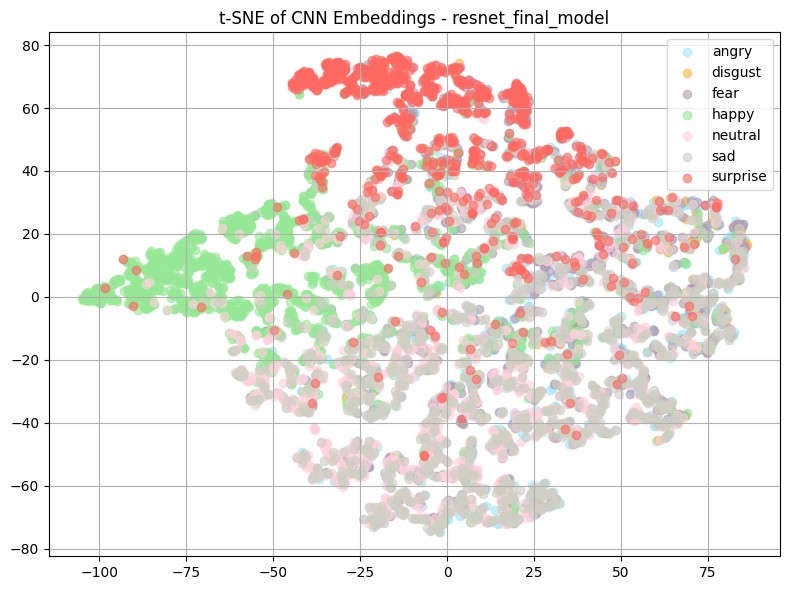

In [52]:
# Load model and extract features
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2_48x48().to(device)
model.load_state_dict(torch.load("results/mobv2_adam_lr3_dropout15_bn"))  # TODO: Pick best model
model.eval()

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        features = model(images)
        all_features.append(features.cpu())
        all_labels.append(labels)

all_features = torch.cat(all_features).numpy()
all_labels = torch.cat(all_labels).numpy()

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(all_features)

# Plot
plt.figure(figsize=(8, 6))
emotion_labels = test_dataset.classes
colors = ['#a0e6fc', '#FFB347', '#B39EB5', "#96E896", '#FFD1DC', '#CFCFC4', '#FF6961']
for idx, label in enumerate(np.unique(all_labels)):
    mask = all_labels == label
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1], label=emotion_labels[label], alpha=0.6, color=colors[idx])

plt.title("t-SNE of CNN Embeddings - mobilenetv2_final_model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("results/tsne_mobv2_final_model.png")
plt.show()

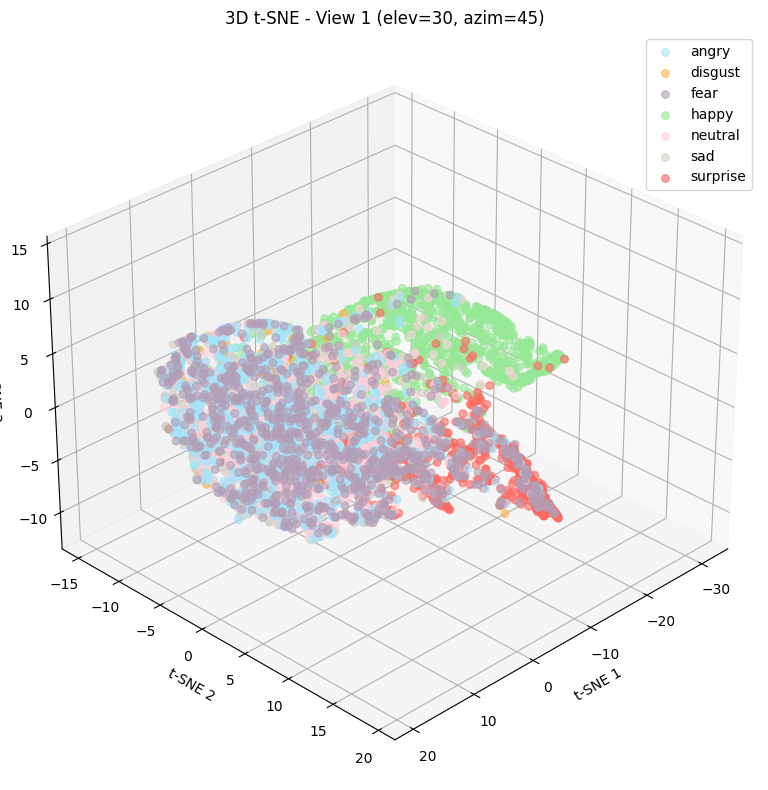

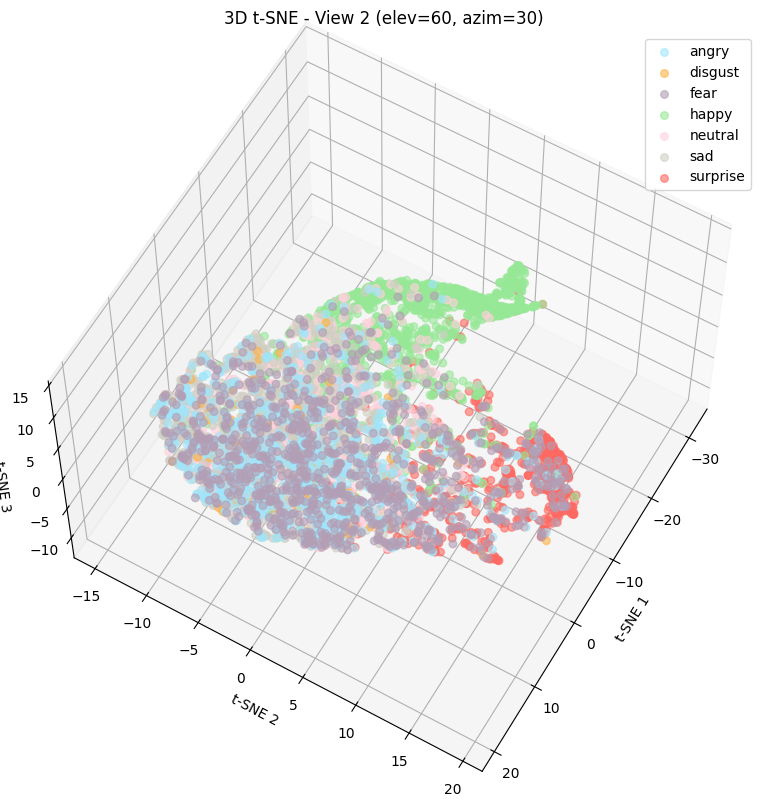

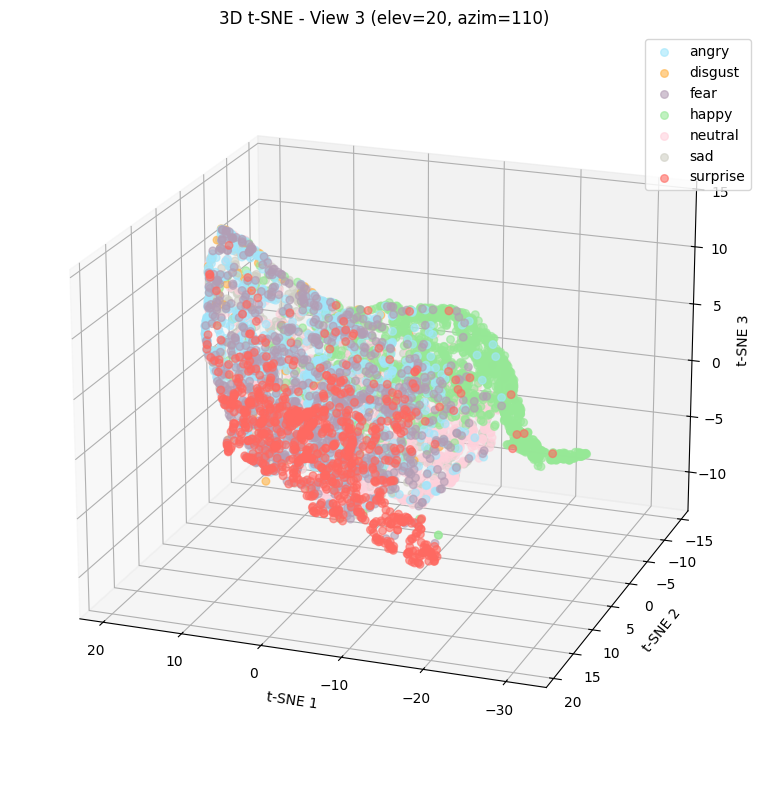

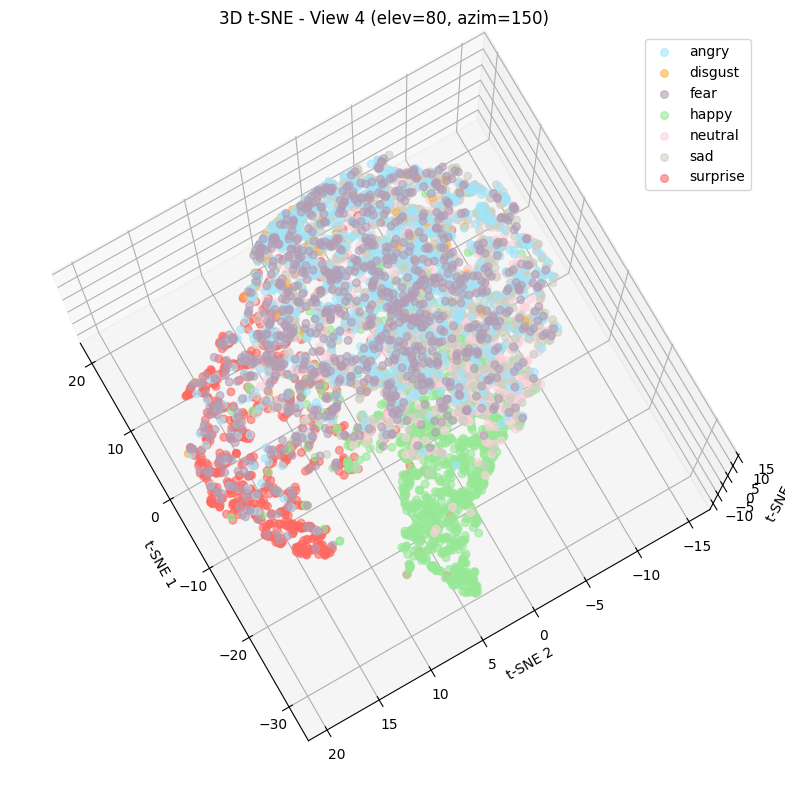

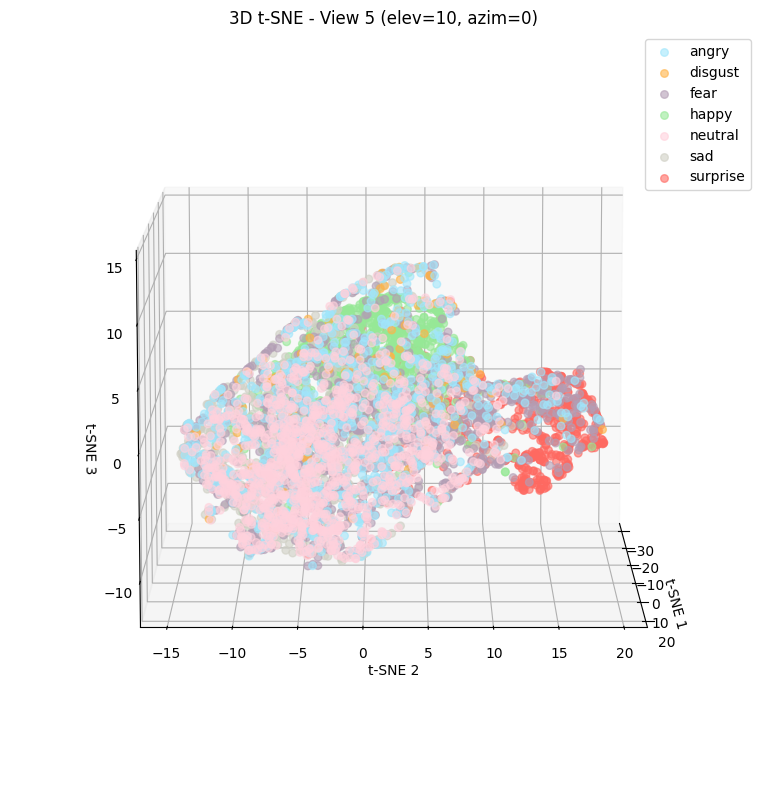

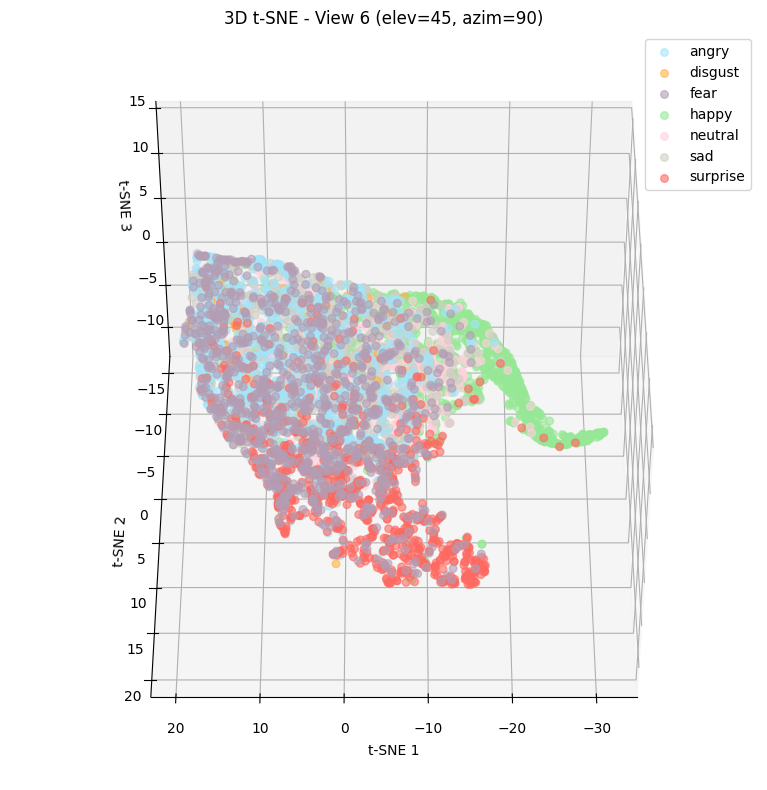

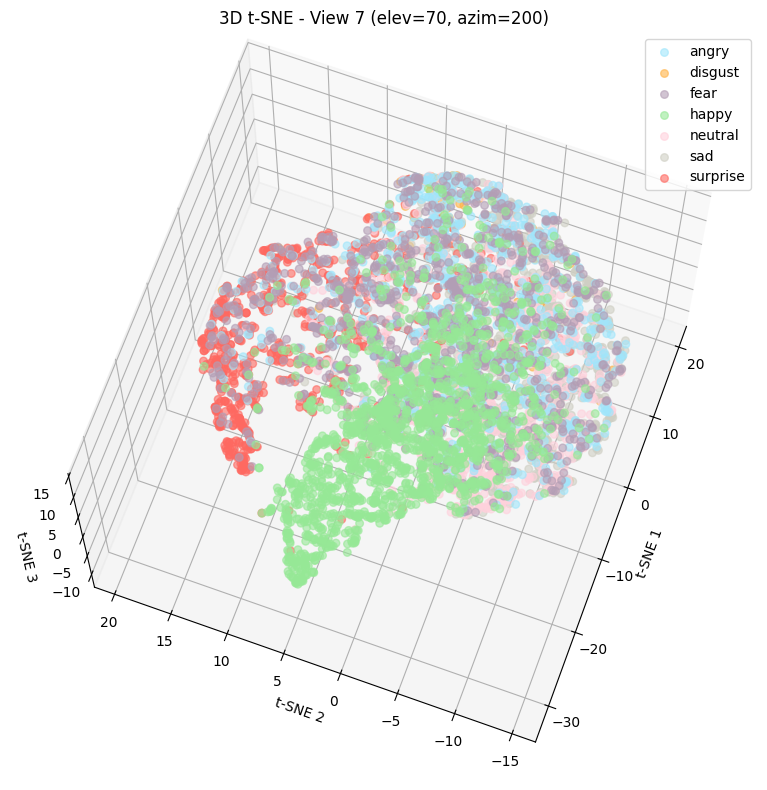

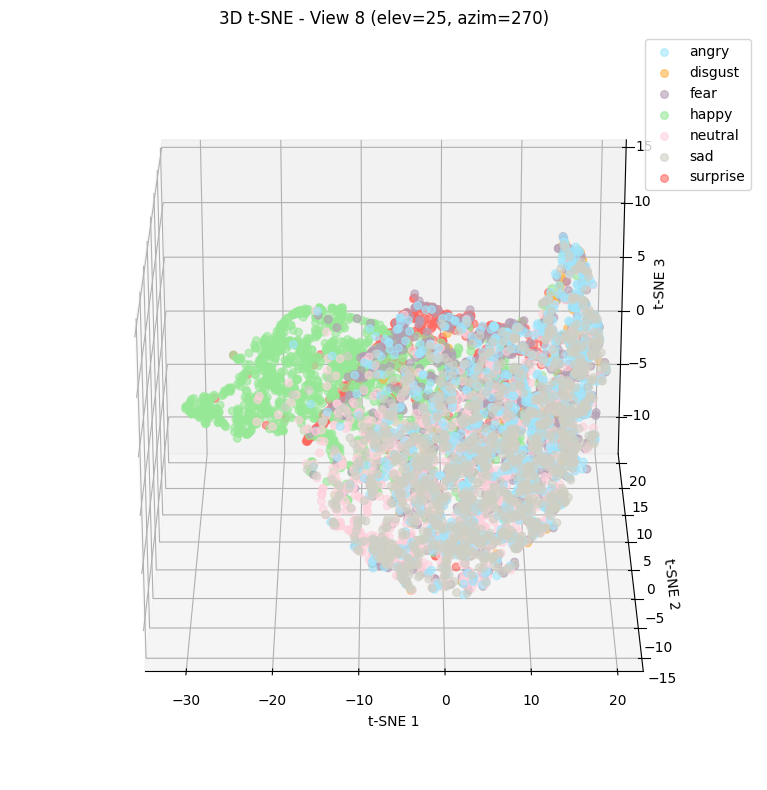

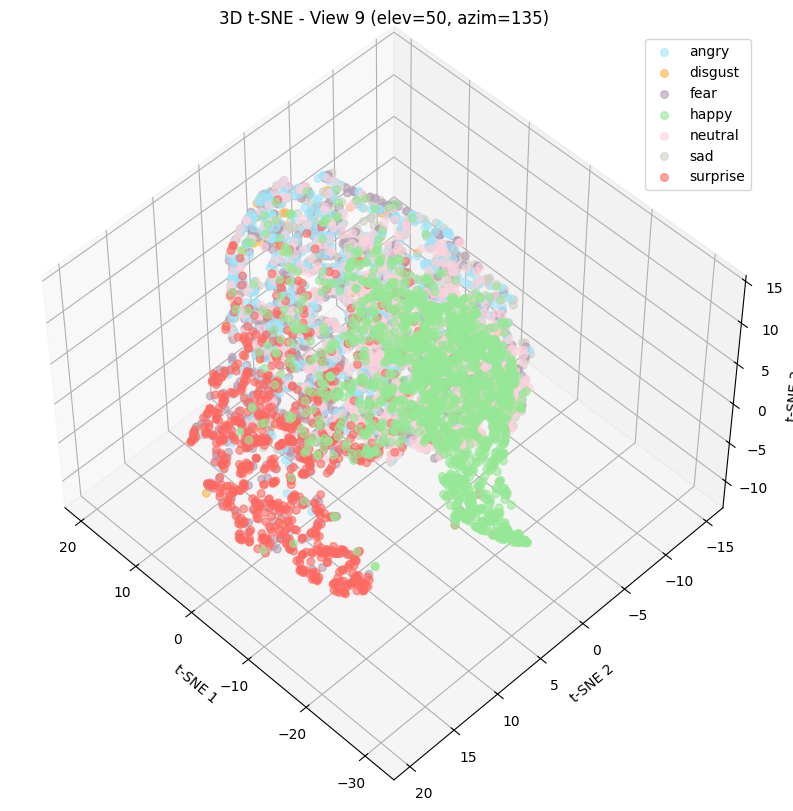

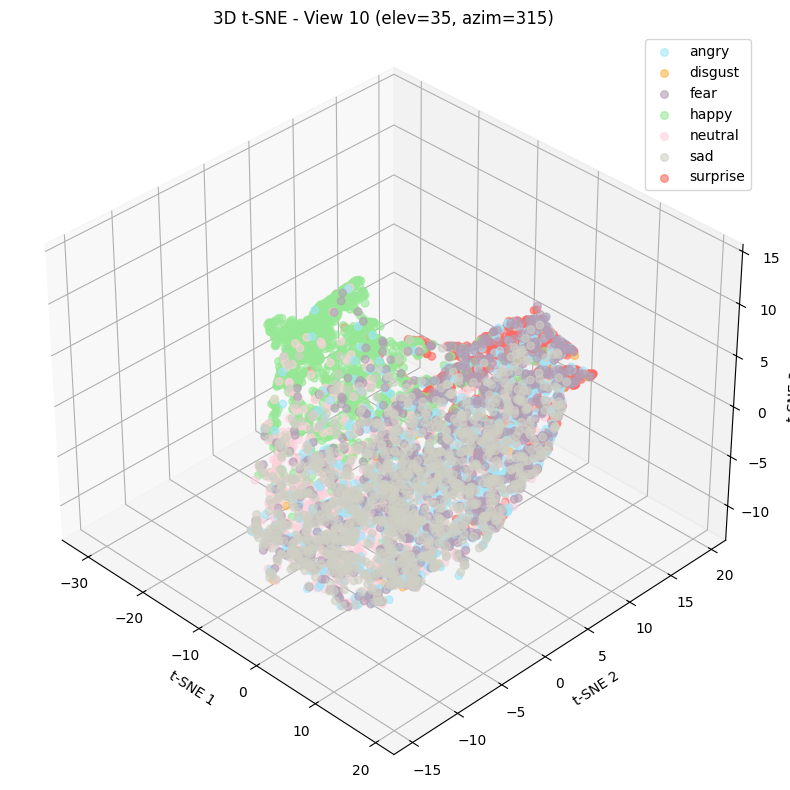

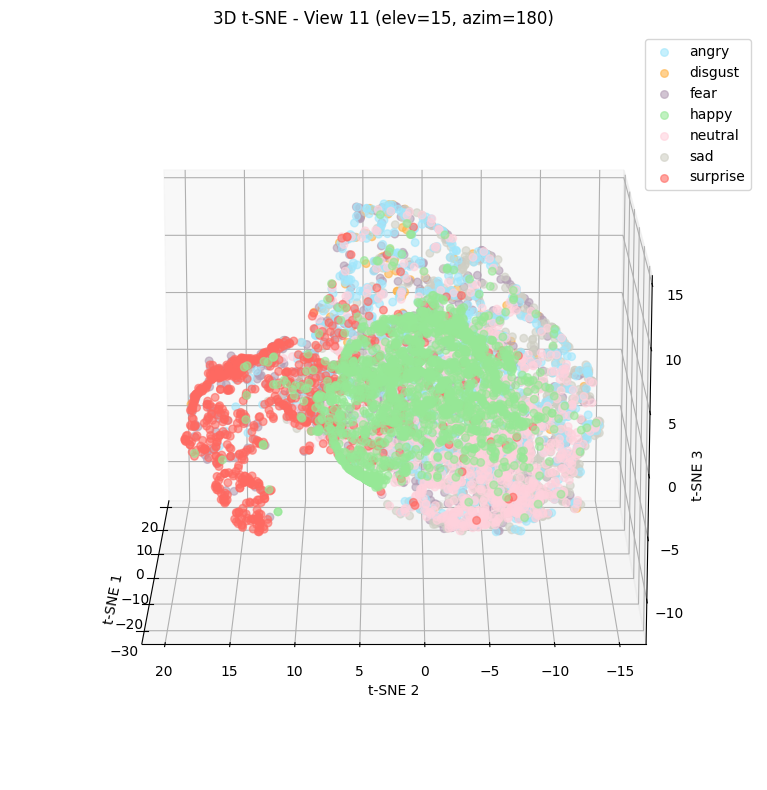

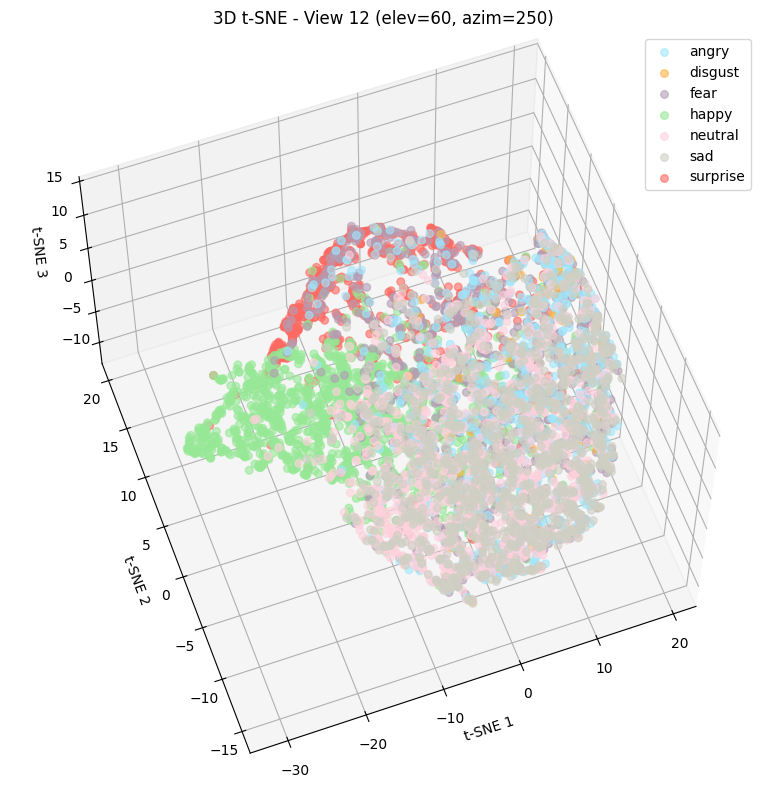

In [53]:
# Run t-SNE with 3 components
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(all_features)

# Settings
emotion_labels = test_dataset.classes
colors = ['#a0e6fc', '#FFB347', '#B39EB5', "#96E896", '#FFD1DC', '#CFCFC4', '#FF6961']
view_angles = [
    (30, 45), (60, 30), (20, 110), (80, 150),
    (10, 0), (45, 90), (70, 200), (25, 270),
    (50, 135), (35, 315), (15, 180), (60, 250)
]

# Plot from multiple angles
for i, (elev, azim) in enumerate(view_angles):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for idx, label in enumerate(np.unique(all_labels)):
        mask = all_labels == label
        ax.scatter(tsne_results[mask, 0], tsne_results[mask, 1], tsne_results[mask, 2],
                   label=emotion_labels[label], alpha=0.6, color=colors[idx], s=30)

    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f"3D t-SNE - View {i+1} (elev={elev}, azim={azim})")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.set_zlabel("t-SNE 3")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"results/tsne3d_mobv2_view{i+1}.png")
    plt.show()